# FISTA
We can formulate the image reconstrucion from the sinogram as an optimization problem as the following:
$$
min_x ||A(x) - b||^2 + 2 \lambda ||x||_{TV}
$$
The formulation of the optimization problem follows the theoretical framework layed out in the citation. First we consider the sinogram data. Let $b \in \mathbb{R}^{mxn}$ be the measured sinogram, where $n$ is the number of x-ray sources and $m$ is the number of angles. $x \in \mathbb{R}^{256^2 X 1}$ be the flattened true image with the resolution of 256X256. A is an affine map representing an operator and $\eta$ is a corresponding additive unknown noise satistifying the additive relation (expand on the sources of noise).

In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as scio

from pyunlocbox import functions
from pyunlocbox import solvers

import plot_utils

In [2]:
plot_utils.set_print_params()

## Datasets
Each dataset is represented by a 3-tuple with values as follows:
* Name of the sinogram file in .mat format
* Name of the imaging operator file
* Prefix for outputting data

In [3]:
data_dir = "data"
results_dir = "results"
# Tuples that are (sinogram file, sinogram variable name, imaging operator file, output prefix)
datasets = [
    (os.path.join(data_dir, "sinogram90.mat"),
        os.path.join(data_dir, "A90.mat"),
        os.path.join(results_dir, "fista90")),
    (os.path.join(data_dir, "sinogram270.mat"),
        os.path.join(data_dir, "A270.mat"),
        os.path.join(results_dir, "fista270")),
    (os.path.join(data_dir, "sinogram540.mat"),
        os.path.join(data_dir, "A540.mat"),
        os.path.join(results_dir, "fistaFull")),
]

In [4]:
# Read in the reference image
ref_image = scio.loadmat(os.path.join(data_dir, "project_data.mat"))["imgref"]

## Regularization parameter search
To find the optimal hyperparameter, we implement an L-curve criterion. In order to speed up the runtime, we first fit the model with the least amount of regularization. Then, we use the solution as an initialization for the next amount of regularization. Note that in `pyunlocbox`, $\lambda$ is used on the data fidelity term, not the regularization term. Therefore, a smaller value of $\lambda$ corresponds to less regularization.

In [5]:
def parameter_search(operator, data, lambdas, image_dims=(256, 256), max_iter=1000, rtol=1e-6):
    models = {}
    
    # Lists for the L-curve
    misfits = []
    regs = []
    
    n_pixels = np.product(image_dims)
    model_init = np.zeros(n_pixels)
    
    for lambda_ in lambdas:
        tv = functions.norm_tv(maxit=50, dim=1)
        fidelity = functions.norm_l2(y=data, A=operator, lambda_=lambda_)
        solver = solvers.forward_backward(step=0.5/lambda_)
        
        # Run FISTA
        result = solvers.solve([tv, fidelity], list(model_init), solver, rtol=rtol, maxit=max_iter)
        # Use the result to initialize the next hyperparameter
        model_init = result["sol"]
        # Convert the result into a matrix
        models[lambda_] = model_init.reshape(image_dims, order="F")
        
        # Compute the data fidelity and model complexity for the L-curve
        misfit = functions.norm_l2().eval(operator.dot(model_init) - data)
        reg = functions.norm_tv(maxit=50, dim=1).eval(model_init)
        misfits.append(misfit)
        regs.append(reg)
        
    # Plot the L-curve
    fig, ax = plt.subplots()
    ax.loglog(regs, misfits)
    for txt, reg, misfit in zip(lambdas, regs, misfits):
        ax.annotate(f"{1/txt:1.2e}", (reg, misfit))
    ax.set_xlabel(r"$||x||_{TV}$")
    ax.set_ylabel(r"$||Ax - d||$")
    
    return models, fig

## Run the algorithm
After plotting the L-curve, show the reconstructed images. Then, we save the reconstructed images to file for downstream quality assessment.

Running FISTA for results/fista90


/home/ryan/miniconda/lib/python3.6/site-packages/pyunlocbox/functions.py:701: RuntimeWarning: invalid value encountered in double_scalars
  rel_obj = np.abs(obj - prev_obj) / obj


Solution found after 321 iterations:
    objective function f(sol) = 1.503862e+04
    stopping criterion: RTOL
    norm_tv evaluation: 1.474707e+04
Solution found after 197 iterations:
    objective function f(sol) = 1.793142e+04
    stopping criterion: RTOL
    norm_tv evaluation: 1.514892e+04
Solution found after 384 iterations:
    objective function f(sol) = 2.943598e+04
    stopping criterion: RTOL
    norm_tv evaluation: 2.091913e+04
Solution found after 1000 iterations:
    objective function f(sol) = 5.822084e+04
    stopping criterion: MAXIT
    norm_tv evaluation: 3.819223e+04
Solution found after 1000 iterations:
    objective function f(sol) = 1.699528e+05
    stopping criterion: MAXIT
    norm_tv evaluation: 6.485673e+04
Solution found after 1000 iterations:
    objective function f(sol) = 5.365794e+05
    stopping criterion: MAXIT
    norm_tv evaluation: 1.034386e+05
Solution found after 1000 iterations:
    objective function f(sol) = 9.437435e+05
    stopping criterion:

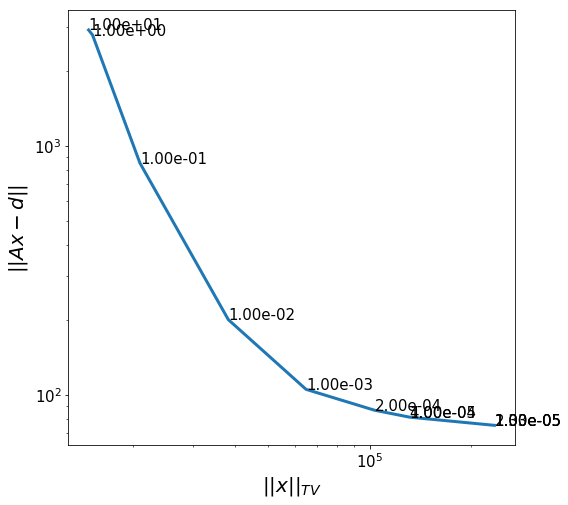

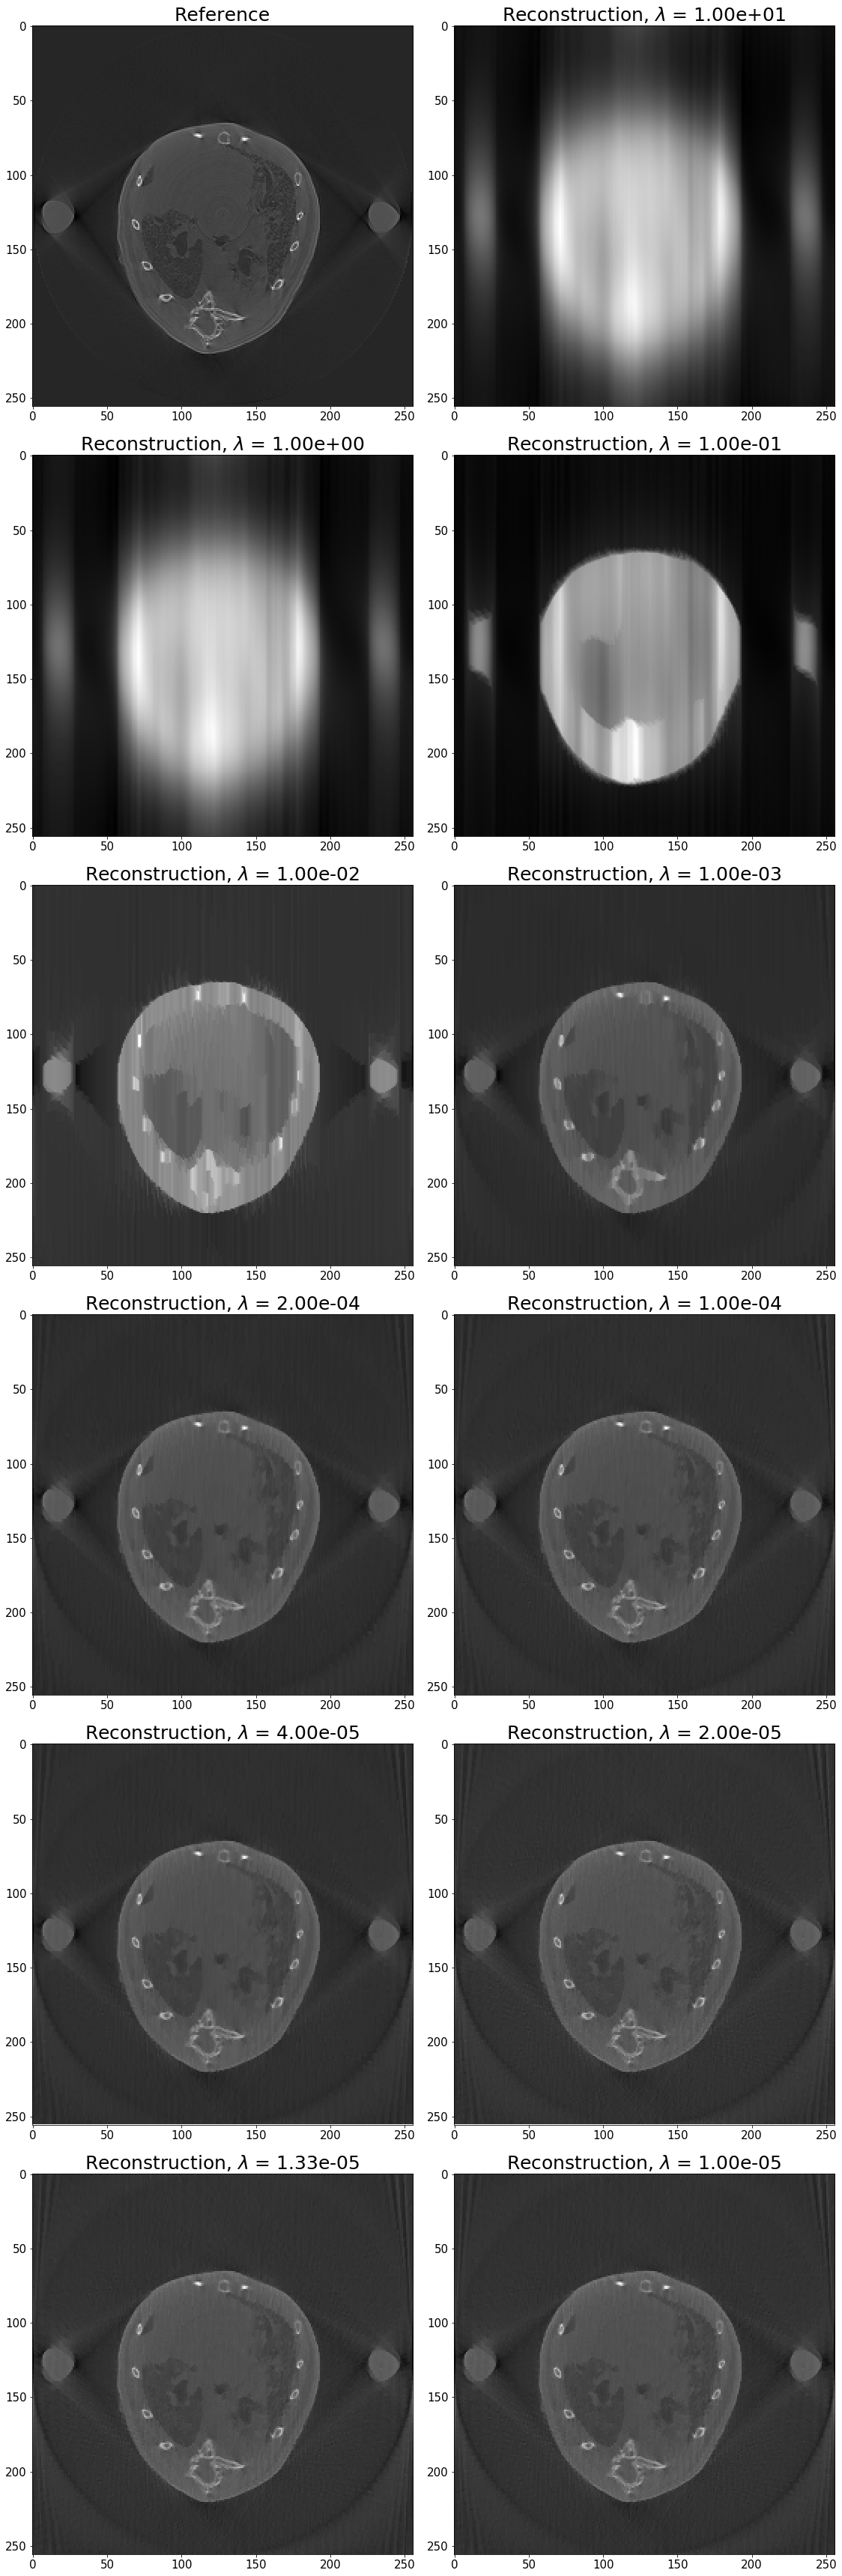

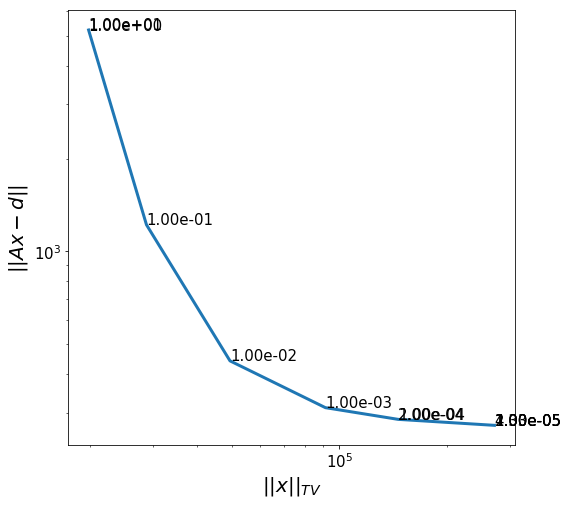

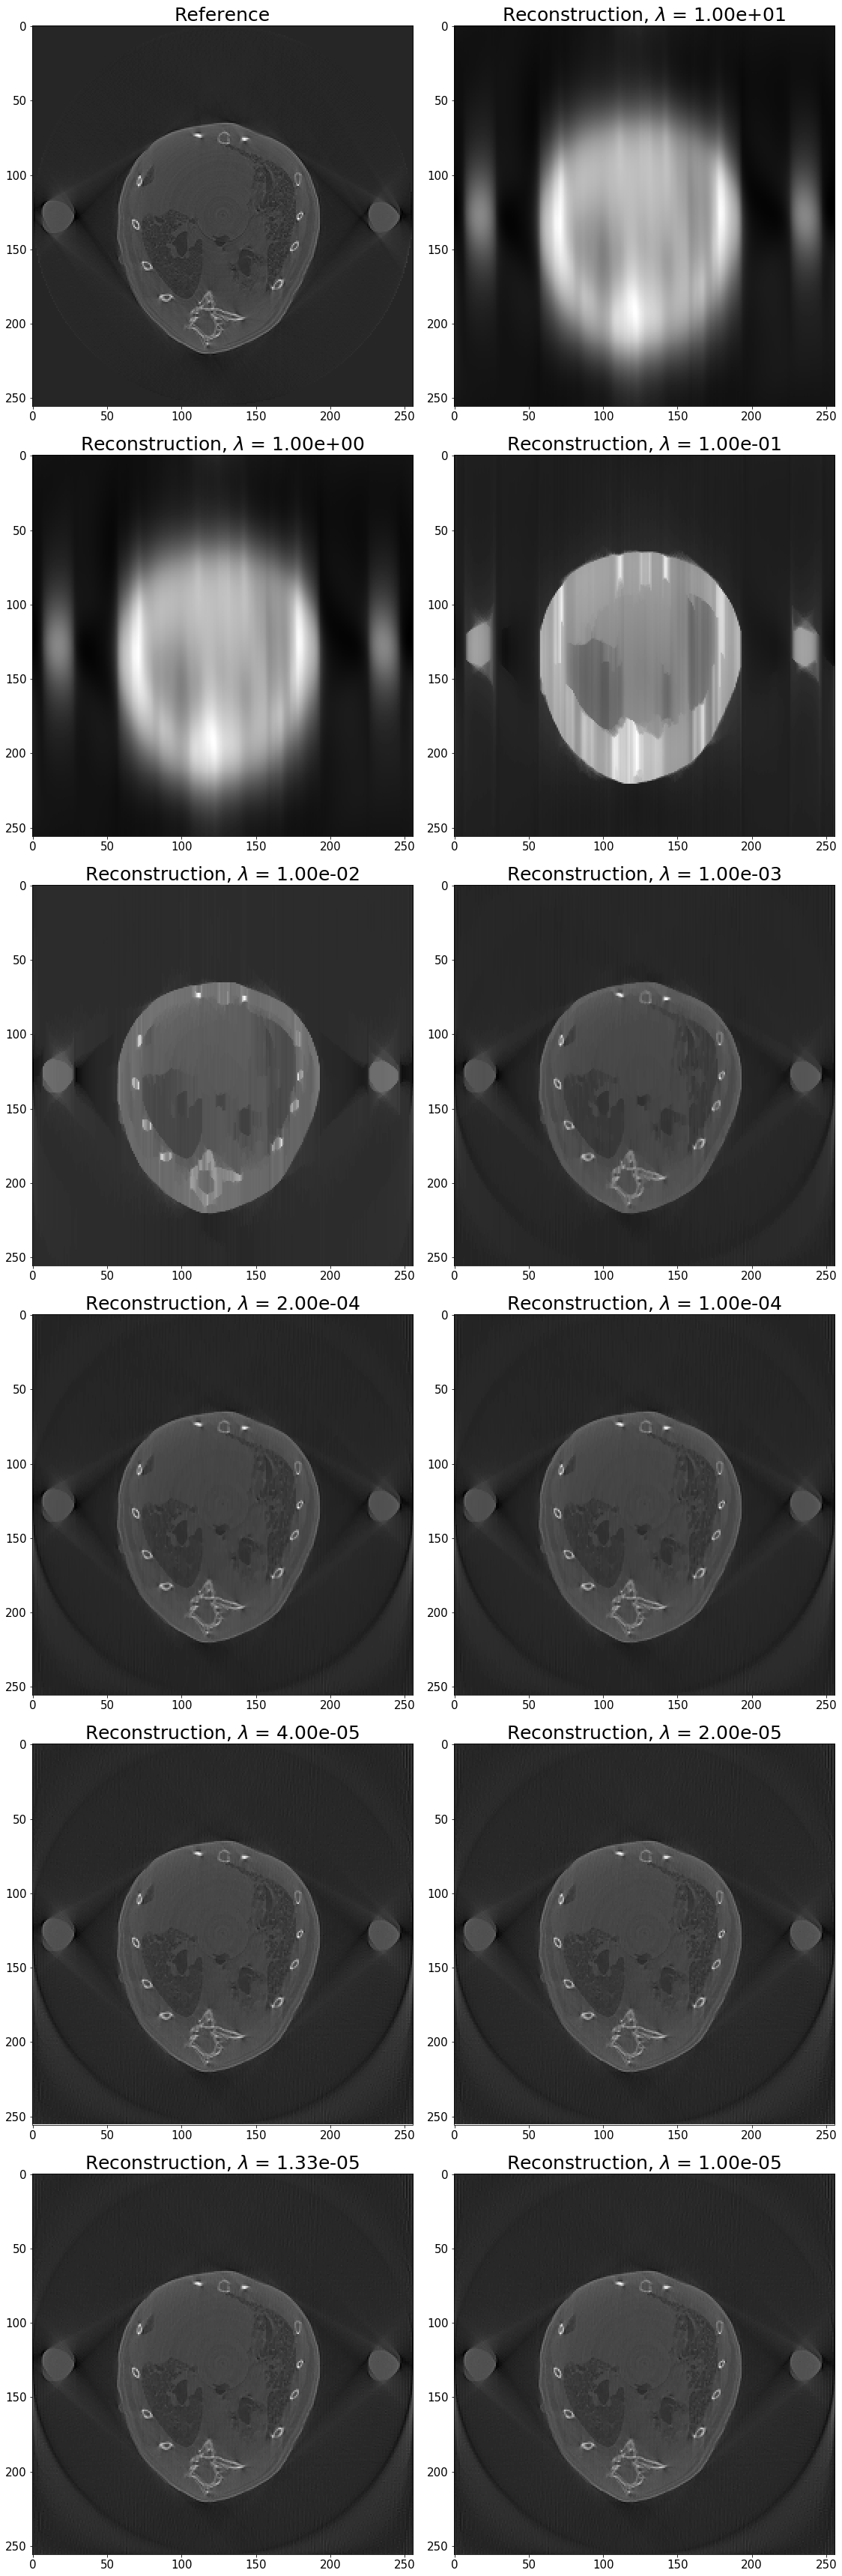

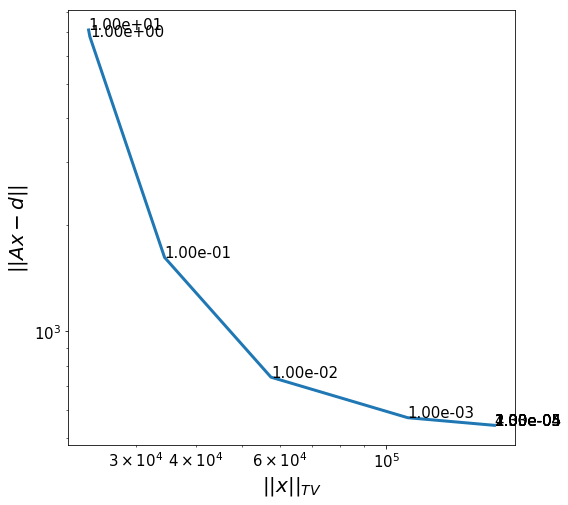

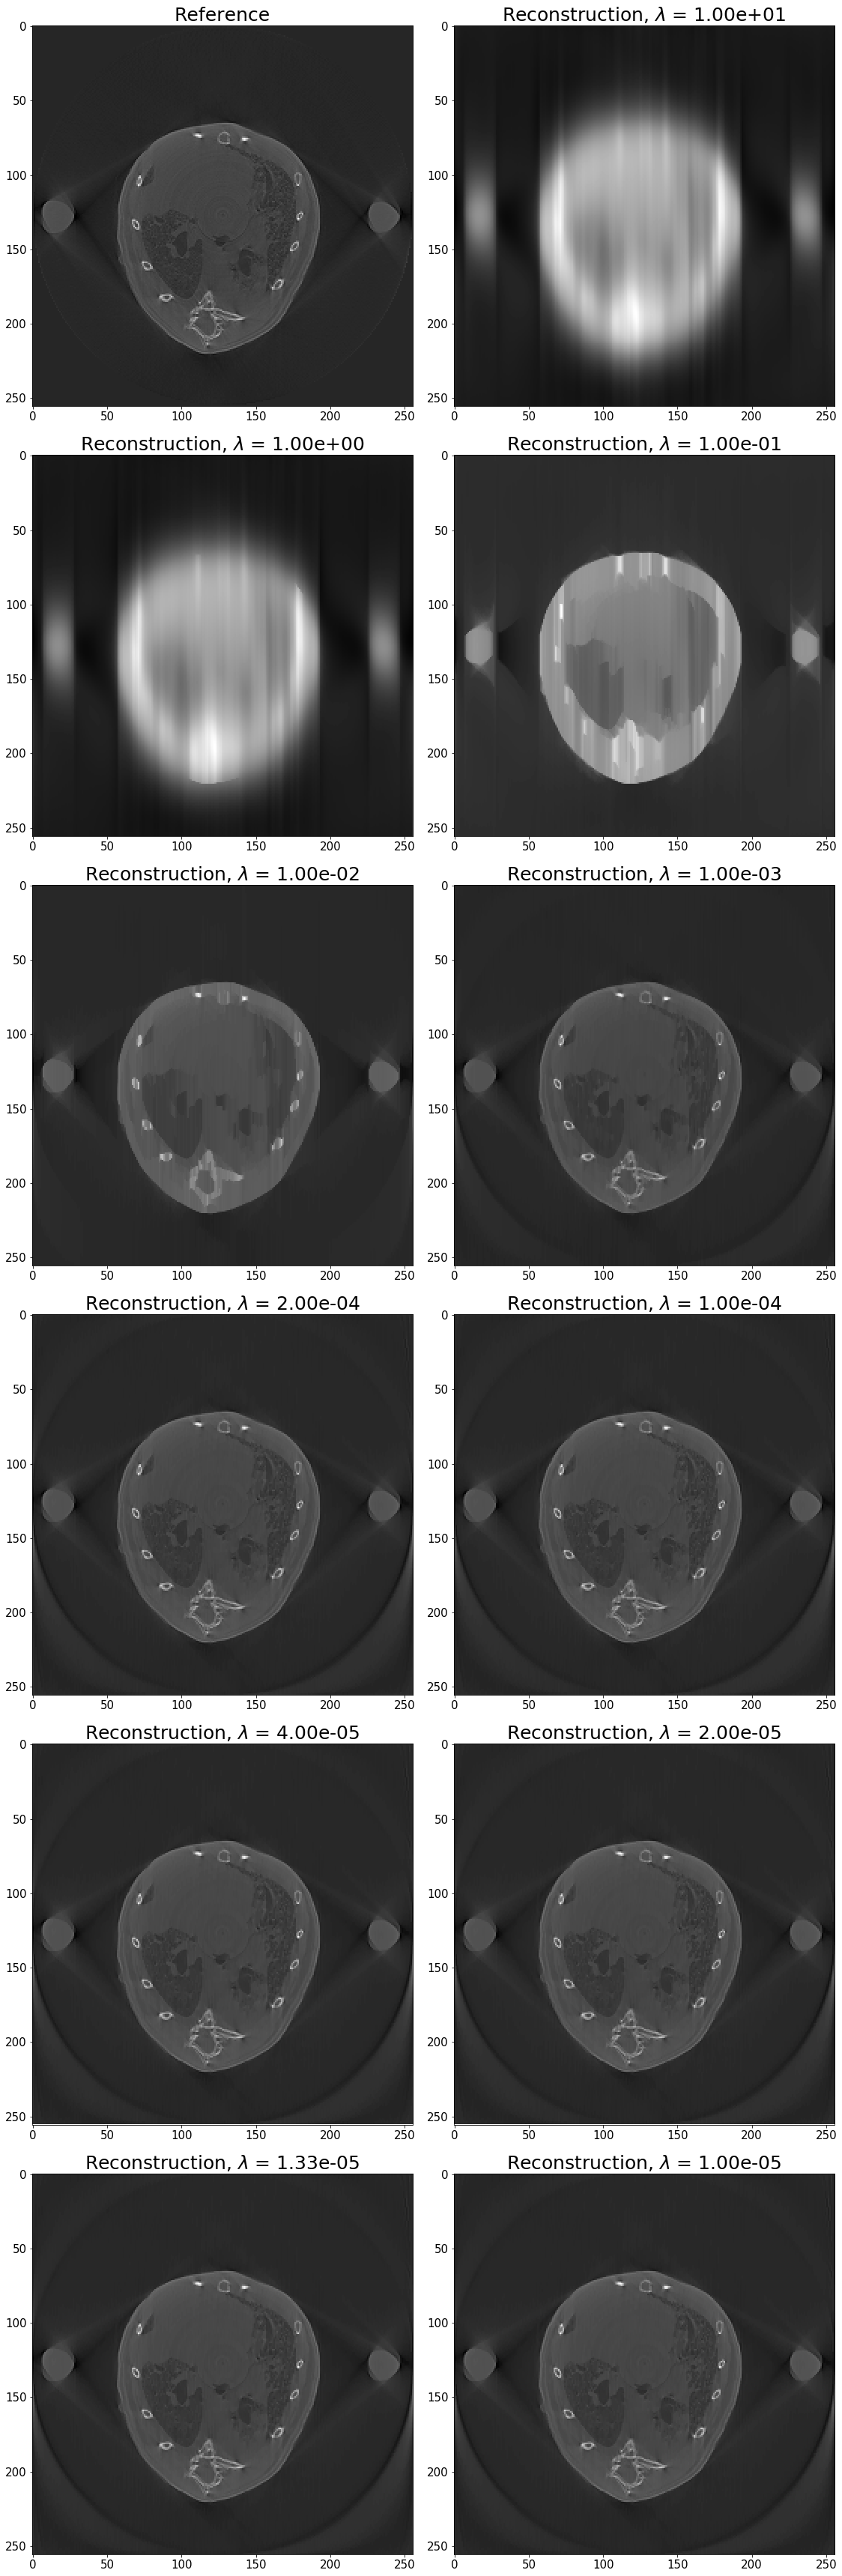

In [6]:
lambdas = [0.1,1,10,100,1000,5000,10000,25000, 50000, 75000, 100000]
for sinogram, operator, out_prefix in datasets:
    print(f"Running FISTA for {out_prefix}")
    # Read in the sinogram
    sinogram = scio.loadmat(sinogram)["sino"]
    sinogram = sinogram.flatten(order="F")
    
    # Read in the imaging operator, convert to CSR format
    operator = scio.loadmat(operator)["A"]
    operator = operator.tocsr()
    models, fig = parameter_search(operator, sinogram, lambdas)
    fig.savefig(f"{out_prefix}Lcurve.png")
    
    # Plot the images
    row_size, col_size = mpl.rcParams["figure.figsize"]
    fig, ax_list = plt.subplots(ncols=2, nrows=6, figsize=(row_size * 2, col_size * 6))
    ax_list = ax_list.ravel()

    # Plot the reference image first
    ax_list[0].imshow(ref_image)
    ax_list[0].set_title("Reference")

    for ax, (lambda_, model) in zip(ax_list[1:], models.items()):
        ax.imshow(model)
        ax.set_title(fr"Reconstruction, $\lambda$ = {1 / lambda_:1.2e}")

        # Save the reconstructions to file
        np.savetxt(f"{out_prefix}Reconstruction_lambda_{1 / lambda_:1.2e}.txt", model)

    fig.tight_layout()
    fig.savefig(f"{out_prefix}Images.png")